In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from src.data.data_fetcher import get_raw_data
from src.features.feature_engineering import prepare_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from src.features.preprocess_data import get_final_prediction
from src.features.preprocess_data import fetch_preprocessed_data, get_preprocessed_test_data

## Step 1: Load data and preprocess it

In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

In [3]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed = get_preprocessed_test_data()

                    time  pv_measurement       date_forecast  \
4355 2019-12-01 09:00:00            4.40 2019-12-01 09:00:00   
4356 2019-12-01 10:00:00           66.00 2019-12-01 10:00:00   
4357 2019-12-01 11:00:00           41.80 2019-12-01 11:00:00   
4358 2019-12-01 12:00:00            4.62 2019-12-01 12:00:00   
4359 2019-12-01 13:00:00            0.00 2019-12-01 13:00:00   

      absolute_humidity_2m:gm3  air_density_2m:kgm3  clear_sky_energy_1h:J  \
4355                     4.800              1.27200           27331.500000   
4356                     4.825              1.27300           98679.046875   
4357                     4.800              1.27350          142199.703125   
4358                     4.750              1.27525          125991.281250   
4359                     4.650              1.27700           61200.398438   

      clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
4355        17.549999        456.250000              0.0      273

In [4]:
# Initialize a Gradient Boosting regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.0001)

# Train the Gradient Boosting model on the cleaned training data
gb_model.fit(X_train_obs_combined, y_train_obs_combined)

GradientBoostingRegressor(random_state=42)

In [5]:
# Predict the target variable on the validation observed data
y_pred_val_obs_combined = gb_model.predict(X_val_obs_combined)
y_pred_val_est_combined = gb_model.predict(X_val_est_combined)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  12.955644753115545
MAE on validation estimated data:  21.582399117667535


In [6]:
# Predict on the cleaned validation set
y_val_pred_est_a = gb_model.predict(X_test_estimated_a_processed)
y_val_pred_est_b = gb_model.predict(X_test_estimated_b_processed)
y_val_pred_est_c = gb_model.predict(X_test_estimated_c_processed)

# Combine the predictions into a single array
y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
y_pred_test_est_combined.shape


            date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2023-04-30 07:00:04 2023-05-01 00:00:00                       4.4   
1 2023-04-30 07:00:04 2023-05-01 00:15:00                       4.3   
2 2023-04-30 07:00:04 2023-05-01 00:30:00                       4.3   
3 2023-04-30 07:00:04 2023-05-01 00:45:00                       4.3   
4 2023-04-30 07:00:04 2023-05-01 01:00:00                       4.3   

   air_density_2m:kgm3  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                1.286                    0.0              0.0   
1                1.287                    0.0              0.0   
2                1.287                    0.0              0.0   
3                1.287                    0.0              0.0   
4                1.287                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1041.199951              0.0      271.700012            0.0  ...   
1       1054.800049     

(2160, 4)

## Step 4: Visualize the results

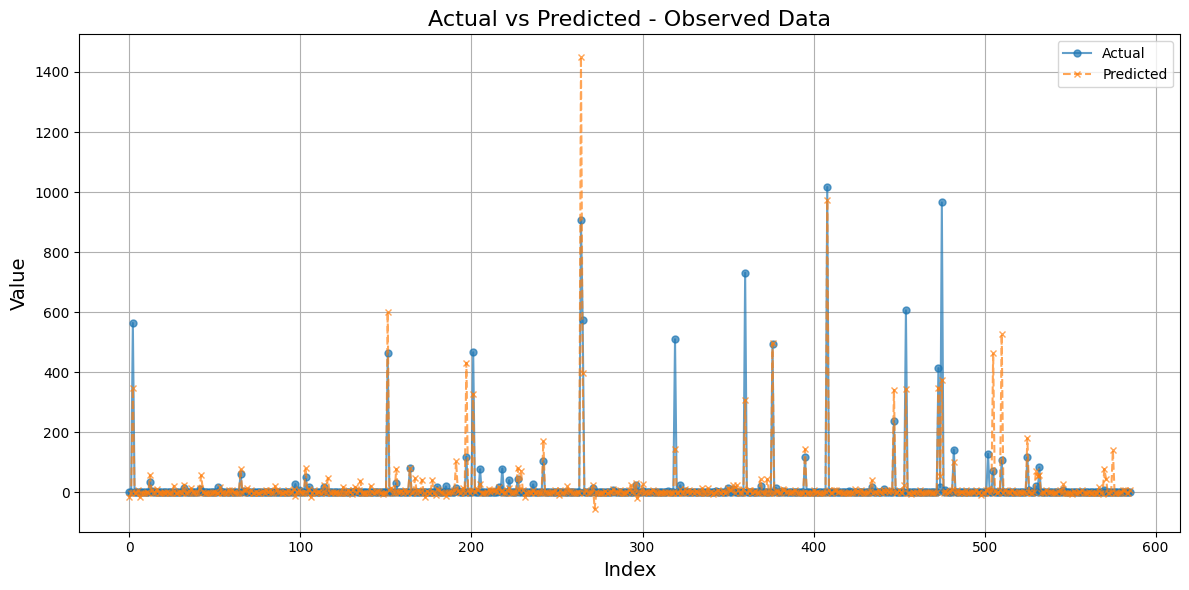

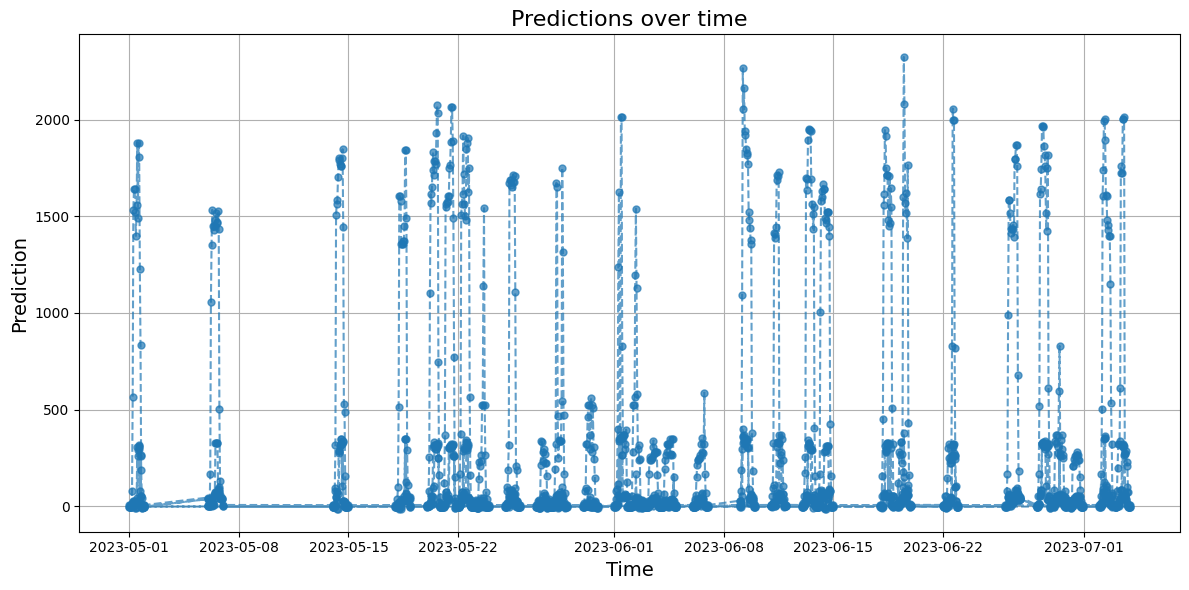

In [7]:

# Set up the plotting area
plt.figure(figsize=(12, 6))

# Line plot of Actual values
plt.plot(y_val_obs_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7)

# Line plot of Predicted values
plt.plot(pd.Series(y_pred_val_obs_combined, index=y_val_obs_combined.index).reset_index(drop=True), label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7)

# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plots
plt.show()

# Plot y_pred_test_est_combined over time
plt.figure(figsize=(12, 6))
plt.plot(y_pred_test_est_combined["time"], y_pred_test_est_combined["prediction"], label='Predicted', linestyle='--', marker='o', markersize=5, alpha=0.7)
plt.title('Predictions over time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Prediction', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 5: Save the model

In [8]:

from src.models.saving import save_predictions


save_predictions(y_pred_test_est_combined, 'gradient_boost_with_time_features_and_location')


   id  prediction
0   0    6.581080
1   1    6.280785
2   2    6.581080
3   3    6.280785
4   4   80.382719
